Analysis of two-port RC data

VNA -> patch pannel -> antennas. Calibration plane is right before the antenna. Big vivaldi is port 2. log periodic is port 1. 



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

# Plotting format 
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

directory = './data_gitignore/'

In [6]:
# Load the DataFrame from CSV
df_HR   = pd.read_csv(directory 
    + "2portRcTest_300MHz_4_14_25_200Steps.csv")       # high resolution = 5kHz. 300-320MHz span, 4000 frequency points
df      = pd.read_csv(directory 
    + "2portRcTest_250_1050MHz_200steps_4_14_25.csv")  # 177.8kHz resolution (sorry), 250-1050MHz, 4500 frequency points
#df_cp   = pd.read_csv(directory 
#    + "2portRcTest_300MHz_4_14_25.csv")   # same as above, but vivaldi is cross polarized (by eye)

# Most of the below is chatgpt. It is kinda dumb, but it works and it was faster than me doing it :)

#Build data frames

# If the S-parameters are stored as strings (e.g., "0.5+0.3j"), convert them to complex numbers.
# If they're already numeric or pre-converted, you can skip this step.
df_HR["S11"] = df["S11"].apply(lambda x: complex(x))
df_HR["S12"] = df["S12"].apply(lambda x: complex(x))
df_HR["S22"] = df["S22"].apply(lambda x: complex(x))

df["S11"] = df["S11"].apply(lambda x: complex(x))
df["S12"] = df["S12"].apply(lambda x: complex(x))
df["S22"] = df["S22"].apply(lambda x: complex(x))



In [35]:
# independent positions

def get_s_at_frequency(target_freq, df, s_parameter):
    """
    Extracts and returns an array of S12 values (complex) from the DataFrame at the frequency
    closest to the given target_freq.
    
    Parameters:
      target_freq (float): The target frequency (in MHz) for which S12 values are needed.
      df (pd.DataFrame): The DataFrame containing the data. This DataFrame is expected to
                         have columns "Sweep time", "Freq_MHz", and "S12".
                         
    Returns:
      np.ndarray: Array of S12 values (complex) corresponding to the frequency closest to target_freq,
                  one per unique "Sweep time" in the DataFrame.
    """
    s_values = []
    
    # Group the dataframe by "Sweep time", so that each group represents a separate sweep.
    groups = df.groupby("Sweep")
    
    # For each sweep, find the row where Freq_MHz is closest to target_freq.
    for sweep_time, group in groups:
        # Calculate the absolute difference between the frequencies and target_freq.
        diff = (group["Freq_MHz"] - target_freq).abs()
        # Get the index of the smallest difference.
        closest_index = diff.idxmin()
        # Extract the S12 value at that index.
        s_val = group.loc[closest_index, s_parameter]
        # Ensure the value is a complex number (if it's a string, convert it).
        if isinstance(s_val, str):
            s_val = complex(s_val)
        s_values.append(s_val)
    
    return np.array(s_values)

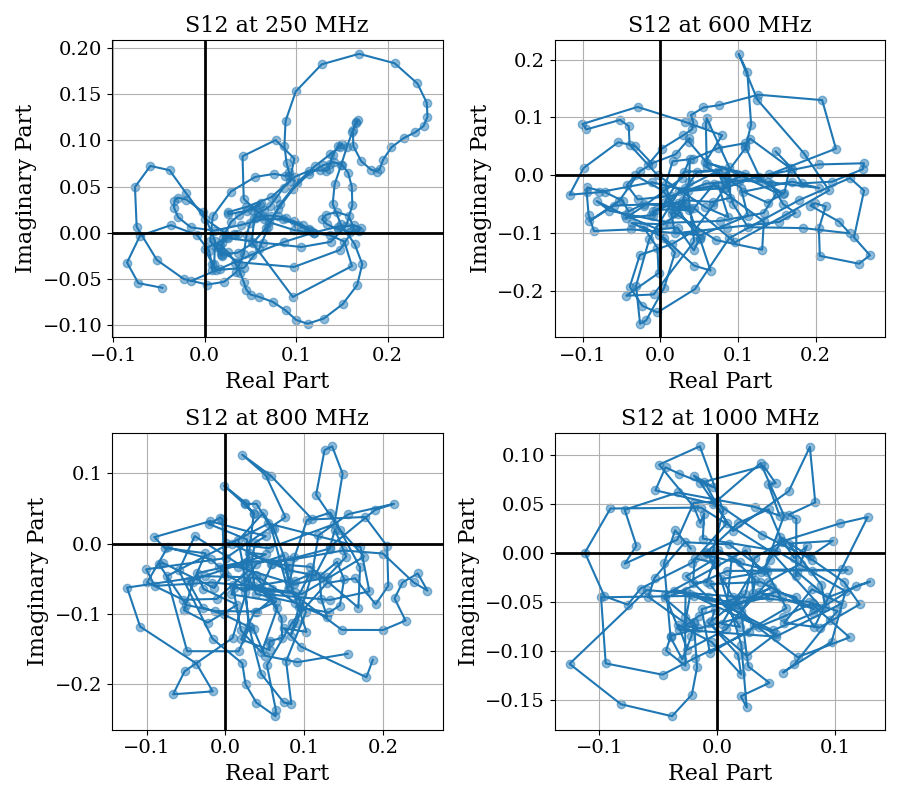

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the list of target frequencies (in MHz).
target_freqs = [250, 600, 800, 1000]

# Prepare a list to hold the S12 arrays.
s12_arrays = []

# Get S12 data for each frequency.
for f in target_freqs:
    s12_array = get_s_at_frequency(f, df, "S12")
    s12_arrays.append(s12_array)

# Create a 2x2 grid of subplots.
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
axs = axs.flatten()  # Flatten to a single list for easier iteration.

# Loop over the target frequencies and corresponding S12 arrays.
for i, f in enumerate(target_freqs):
    s12_arr = s12_arrays[i]
    axs[i].plot(np.real(s12_arr), np.imag(s12_arr))
    axs[i].scatter(np.real(s12_arr), np.imag(s12_arr), alpha = .5)
    axs[i].set_xlabel("Real Part")
    axs[i].set_ylabel("Imaginary Part")
    axs[i].set_title(f"S12 at {f} MHz")
    axs[i].grid(True)
    # Add bold lines at the origin (0,0)
    axs[i].axhline(y=0, color='black', linewidth=2)
    axs[i].axvline(x=0, color='black', linewidth=2)
    

plt.tight_layout()
plt.show()


Text(0, 0.5, 'abs($S_{11}$)')

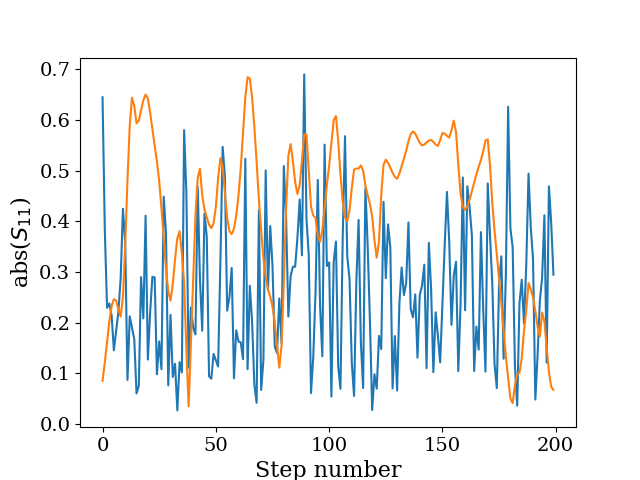

In [53]:
S11_HR  = get_s_at_frequency(301.2, df_HR, "S11")
S11      = get_s_at_frequency(301.2, df, "S11")
plt.close('all')

plt.figure()
plt.plot(abs(S11_HR))
plt.plot(abs(S11))
plt.xlabel('Step number')
plt.ylabel(r'abs($S_{11}$)')


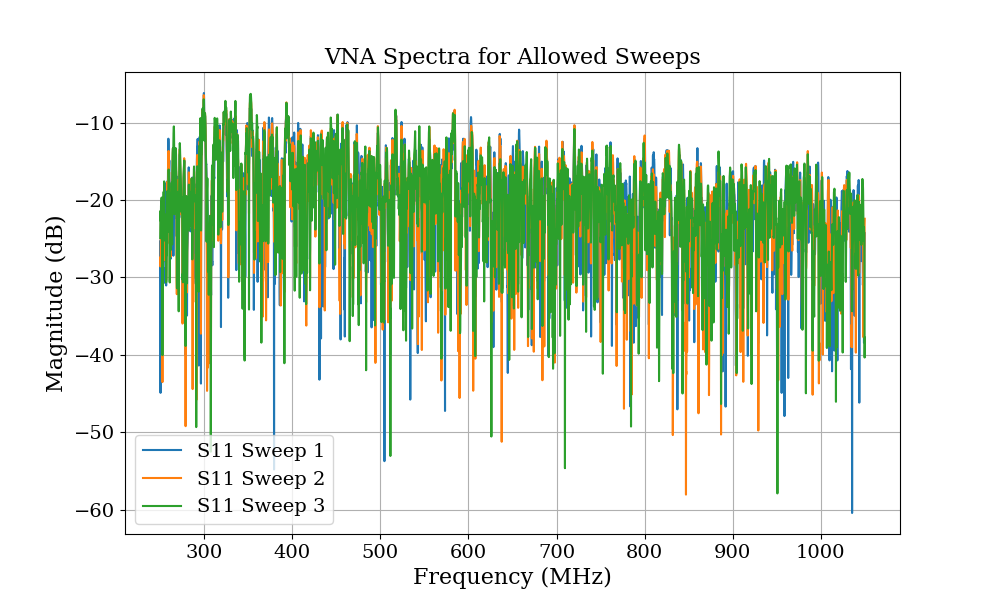

In [58]:
# Specify the list of sweeps you want to plot.
allowed_sweeps = [1,2,3]

# Create a new figure.
plt.figure(figsize=(10, 6))

# Group the data by sweep number and plot only the selected sweeps.
for sweep, group in df.groupby("Sweep"):
    if sweep not in allowed_sweeps:
        continue  # Skip sweeps that are not in the allowed list
    
    freqs = group["Freq_MHz"]
    # Compute magnitudes in dB for each parameter.
    s11_db = 20 * np.log10(np.abs(group["S12"]))
    #s12_db = 20 * np.log10(np.abs(group["S12"]))
    #s22_db = 20 * np.log10(np.abs(group["S22"]))
    
    plt.plot(freqs, s11_db, label=f"S11 Sweep {sweep}")
    # Uncomment the following line if you want to plot S12 as well.
    # plt.plot(freqs, s12_db, label=f"S12 Sweep {sweep}")
    #plt.plot(freqs, s22_db, label=f"S22 Sweep {sweep}")

# Label the plot appropriately.
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("VNA Spectra for Allowed Sweeps")
plt.legend()
plt.grid(True)
plt.show()


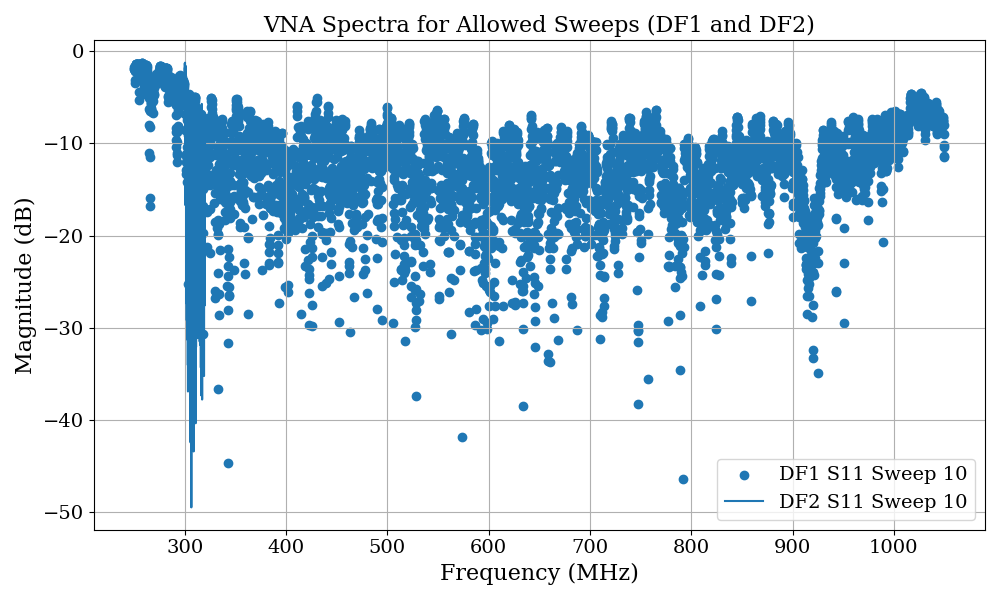

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the list of sweeps you want to plot.
allowed_sweeps = [10]

plt.figure(figsize=(10, 6))

# Plot data from df1.
for sweep, group in df.groupby("Sweep"):
    if sweep not in allowed_sweeps:
        continue  # skip sweeps not in the allowed list
    freqs = group["Freq_MHz"]
    s11_db = 20 * np.log10(np.abs(group["S11"]))
    s22_db = 20 * np.log10(np.abs(group["S22"]))
    plt.scatter(freqs, s11_db, label=f"DF1 S11 Sweep {sweep}")
    #plt.plot(freqs, s22_db, marker='s', linestyle='-', label=f"DF1 S22 Sweep {sweep}")

# Plot data from high res.
for sweep, group in df_HR.groupby("Sweep"):
    if sweep not in allowed_sweeps:
        continue
    freqs = group["Freq_MHz"]
    s11_db = 20 * np.log10(np.abs(group["S11"]))
    s22_db = 20 * np.log10(np.abs(group["S22"]))
    plt.plot(freqs, s11_db, label=f"DF2 S11 Sweep {sweep}")
    #plt.plot(freqs, s22_db, marker='s', linestyle='--', label=f"DF2 S22 Sweep {sweep}")

plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("VNA Spectra for Allowed Sweeps (DF1 and DF2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


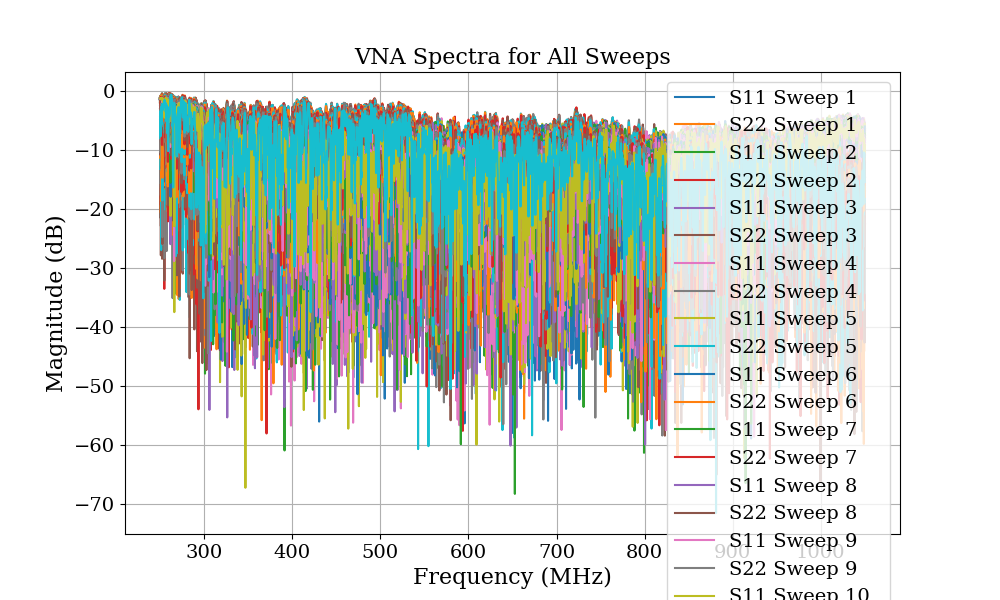

In [49]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Group the data by sweep number and plot each spectrum on the same plot.
for sweep, group in df.groupby("Sweep"):
    freqs = group["Freq_MHz"]
    # Compute magnitudes in dB for each parameter
    s11_db = 20 * np.log10(np.abs(group["S11"]))
    s12_db = 20 * np.log10(np.abs(group["S12"]))
    s22_db = 20 * np.log10(np.abs(group["S22"]))
    
    plt.plot(freqs, s11_db, label=f"S11 Sweep {sweep}")
    #plt.plot(freqs, s12_db, label=f"S12 Sweep {sweep}")
    plt.plot(freqs, s22_db, label=f"S22 Sweep {sweep}")

# Label the plot appropriately
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("VNA Spectra for All Sweeps")
plt.legend()
plt.grid(True)
plt.show()
